In [10]:
using DataStructures
using DSP.Periodograms: freq, power, welch_pgram
using AbstractFFTs: fftshift
using RTLSDR
using Plots

In [11]:
# Task: generate IQ data
function iq_source(sdr, num_samp, channel)
    # sdr: RtlSdr instance
    # num_samp: number of samples to read per call
    # channel: Channel instance to dump iq samples into
    while true
        s = read_samples(sdr, num_samp)
        for i=1:num_samp
            put!(channel, s[i])
        end
    end
end

iq_source (generic function with 1 method)

In [49]:
fc = 91.3e6 # center tuning frequency (Hz)
rate = 3.2e6 # sample rate (Hz)
num_samp = 2^8 # number of samples to read per call

sdr1 = RtlSdr()
set_freq(sdr1, fc)
set_rate(sdr1, rate)

# sdr2 = RtlSdr()
# set_freq(sdr2, fc)
# set_rate(sdr2, rate)

Found Rafael Micro R820T tuner
Exact sample rate is: 2000000.052982 Hz
[R82XX] PLL not locked!


In [50]:
# IQ channel storage limited by memory:
sink_capacity = 2^13
c1 = Channel{Complex{Float64}}(sink_capacity)
# c2 = Channel{Complex{Float64}}(1024)
taskHdl_1 = @task iq_source(sdr1, num_samp, c1)
# taskHdl_2 = @task iq_source(sdr2, c2)
schedule(taskHdl_1)
# schedule(taskHdl_2)

iq_chunk1 = Array{Complex{Float64}}(undef, sink_capacity)
# iq_chunk2 = Array{Complex{Float64}}(undef, sink_capacity)


anim = @animate for i=1:2^8
    for j=1:sink_capacity
        val = take!(c1)
        iq_chunk1[j] = val
#         iq_chunk2[j] = take!(c2)
    end
    p = welch_pgram(iq_chunk1, fs=rate)
    fs = fftshift(freq(p)) .+ fc
    ps = fftshift(10. .* log10.(power(p)))
    plot(fs, ps,
         ylimit=(-125, -50)
    )
    i+=1
end

close(c1)
# close(c2)

┌ Info: Saved animation to 
│   fn = C:\Users\trump\tmp.gif
└ @ Plots F:\Julia\.julia\packages\Plots\6RLiv\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\trump\\tmp.gif")
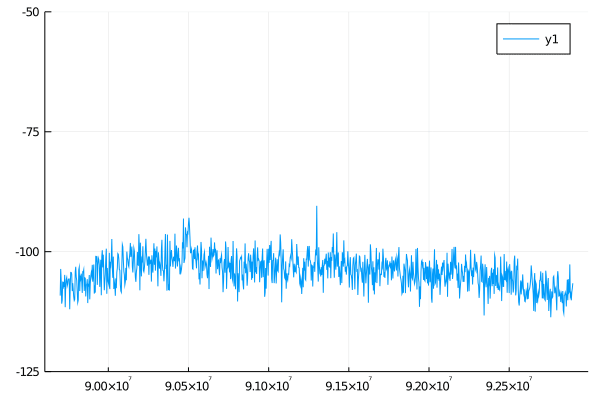

In [51]:
gif(anim)

In [48]:
close(sdr1)
#close(sdr2)

false